# Tutorial 1 - Construction of 1D free energy profile using WHAM

## Introduction

This notebook illustrates the basic usage of ThermoLIB to construct a 1D free energy profile from umbrella sampling simulations using the WHAM methodology, including error estimation from the theory of the maximum likelihood estimator (MLE). The notebook uses simulation data generated using the umbrella sampling technique for the proton transfer in a formic acid dimer.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import BaseFreeEnergyProfile, SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D
from thermolib.tools import read_wham_input, decorrelate, plot_histograms_overlap_1d, plot_histograms_1d
from thermolib.thermodynamics.trajectory import ColVarReader
from thermolib.units import *

import numpy as np

Define some file/path variables

In [3]:
fn_meta = 'data/formic_acid_dimer/wham_input.txt' #location of the plumed metadata file containing all information of the umbrella sampling

## WHAM without error estimation

First read the input trajectories and define the corresponding bias potentials of each biased simulations included in the metadata file. This is done using the ``read_wham_input`` routine in the code block below. Assuming a metadata file with lines in the form of:

    u80  0.38976377952755903   3500.0

we interpret the metadata file using the keywords of the ``read_wham_input`` routine below as follows. A simulation was done with a bias potential of type ``'Parabola1D'`` with ``Q0 = 0.38976`` and ``kappa = 3500.0`` and was given the label ``u80``. In the code block below, we define the unit of ``Q0`` as ``au`` and that of ``kappa`` as ``kjmol``. Furthermore, the corresponding trajectory of Q values during this simulation is stored in a file with path ``colvars/COLVAR_u80.dat`` relative to the metadata file directory. This file is then read by ``colvar_reader`` which is an instance of ``ColVarReader`` class and assumes the file to be a colvar file that stores the values of Q in column ``0`` of a numpy file in units ``au``. Finally, the temperature is also read from the metadata file from the line (usually the first line) that starts with ``T``.

In [4]:
colvar_reader = ColVarReader([0], units=['au'])
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)

The output for the ``read_wham_input`` routine shows (at least if the keyword ``verbose`` is set to ``True``) for each simulation from which file the CV data is read, how many samples are in that simulation as well as which bias potential is used. Before we continue, we should check whether the various Umbrella simulations have sufficiently overlapping histograms. We could simply plot all histograms on top of each other in a single plot:

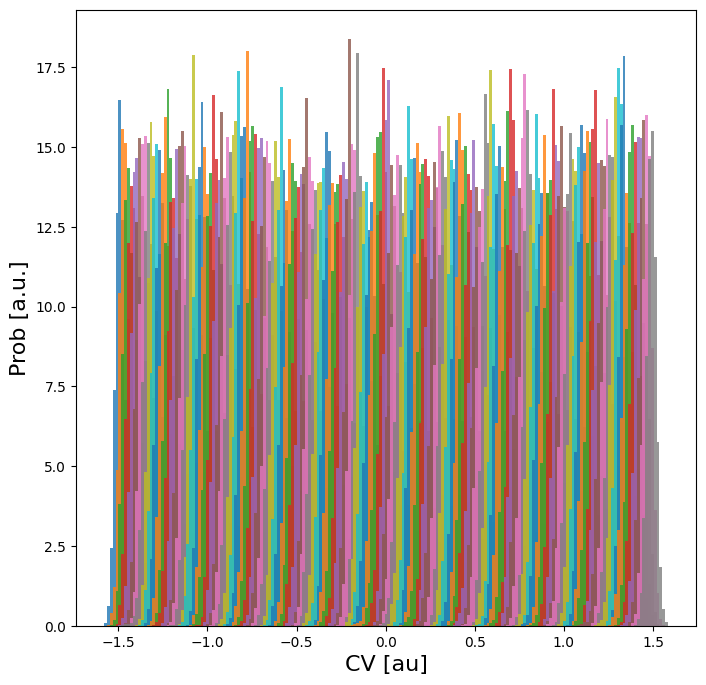

In [5]:
plot_histograms_1d(trajectories)

As it is in this case difficult to assess the overlap (because there are many small histograms), we can also compute the overlap (according to a metric suggested by Borgmans et al. [J. Chem. Theory Comput. 2023, 19, 9032-9048] which is a value between 0 (no overlap) and 1 (perfect overlap)) and plot that:

<Figure size 640x480 with 0 Axes>

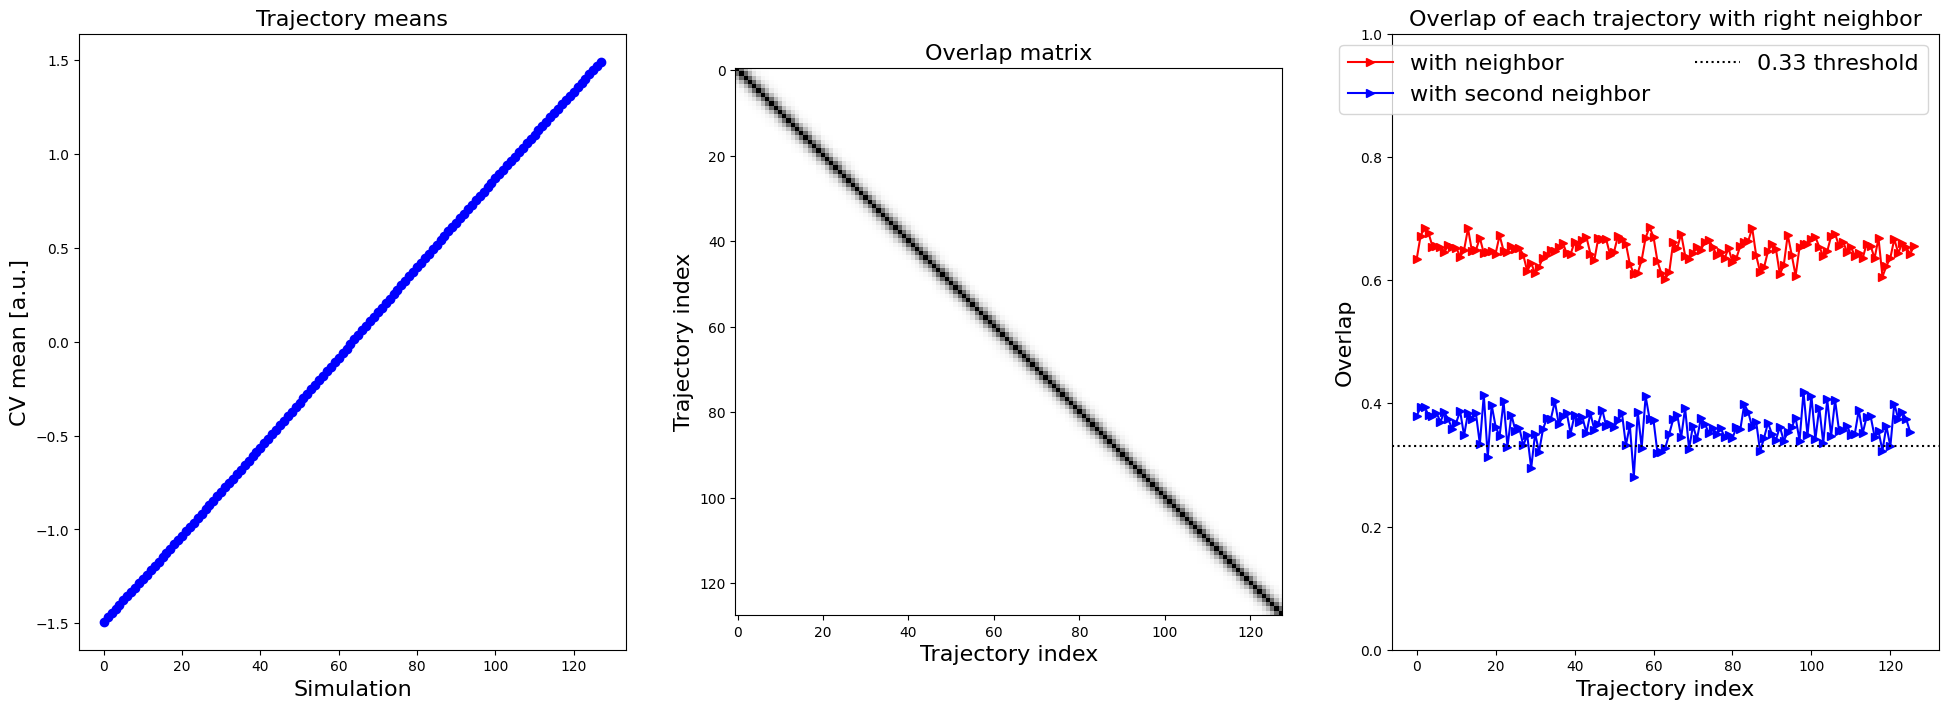

In [6]:
plot_histograms_overlap_1d(trajectories)

In the right plot, which shows the overlap of each trajectory with its right neighbor (as well as its right second neighbor), we see a consistent overlap of more than 0.6, which is rather high. Even the overlap with the second neighbor is still above 0.33, a threshold suggested for another system by Borgmans et al. [J. Chem. Theory Comput. 2023, 19, 9032-9048]. Hence, we are confident the various simulations are sufficiently overlapping. Next, we construct the 1D probability histogram on the given grid (defined by ``bins``) using the WHAM routine.

In [7]:
bins = np.arange(-1.7, 1.7, 0.02)
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, Nscf=10000)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.010s
  bias poten. : 00h 00m 00.006s
  solve scf   : 00h 00m 00.167s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.184s
---------------------------------------------------------------------


We can plot the histogram:

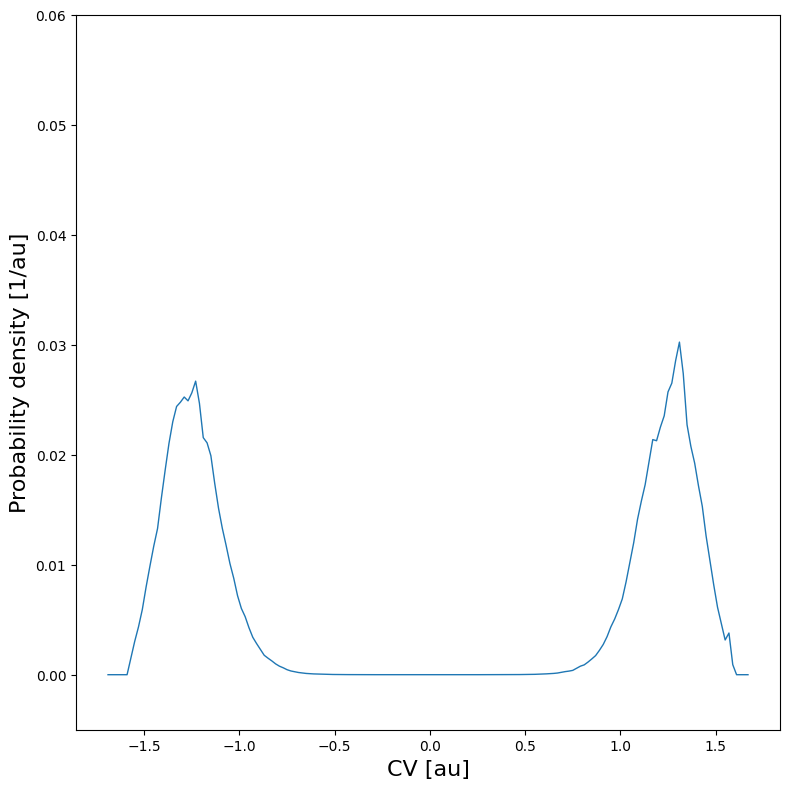

In [8]:
hist.plot(plims=[-0.005,0.06])

From the histogram, we can construct the corresponding free energy profile. We assume the profile contains a single transition state maximum within the Q-range of ``[-0.2,0.2]``, and a reactant state minimum for lower Q value and product state minimum for higher Q value. This is encoded in the class ``SimpleFreeEnergyProfile``. We then also define the energy reference by setting the reactant state minimum to zero and plot the resulting profile.

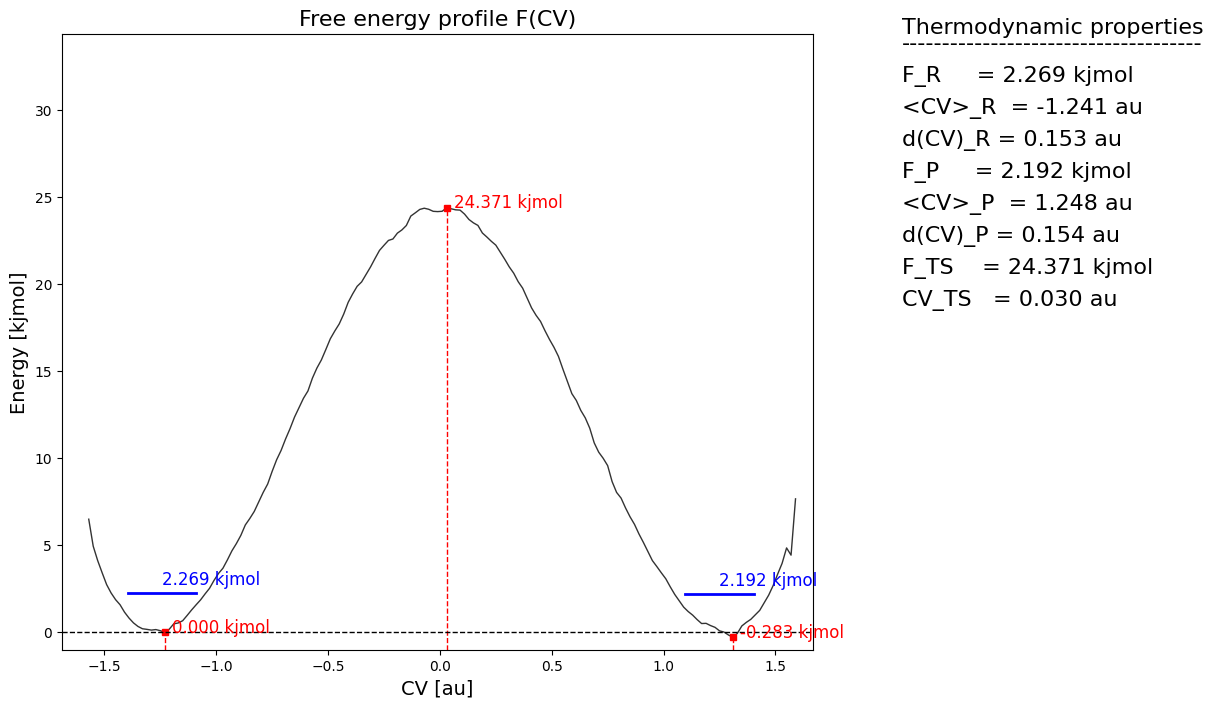

In [9]:
fep = SimpleFreeEnergyProfile.from_histogram(hist, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep.set_ref(ref='r')
fep.plot()

## WHAM with error estimation

Using the same simulation data (and bias potentials) of the previous section, we repeat the WHAM histogram construction and corresponding free energy profile derivation, but now with error estimation. Such error estimation can be done in distinct ways using the theory of Maximum Likelihood Estimators (MLE): `mfe_f` and `mle_p` both use the theory of the Fisher information matrix to compute the error on an MLE, but the first computes the error on the MLE of the free energy directly (and assumes it to be Normally distributed, resulting in an error on the probability to be LogNormally distributed), while the second computes the error on the MLE of the probability (and assumes it to be normally distributed) and then transforms it to an error on the free energy. In general the `mle_f` method is more accurate as it takes explicitly into account that the probabilty should be positive, but if the error is overall small, `mle_f` and `mle_p` are equivalent as will be shown below. 

Finally, both methods ca be augmented with the additional suffix `_cov` indicate that not only the diagonal elements of the covariance matrix (i.e. error on each point of fep individually) is accounted for, but also all off-diagonal elements (i.e. the correlation between free energy of different points on the fep). Even though such covariance matrix will not influence the overall error bars on the full profile itself, it will have a big impact in generating samples of the full profile within the estimated error for propagation to the error on derived properties. 

For more information and guidelines on the various schemes of error estimation, we refer to the `advanced_wham1D_error` notebook, here we will only demonstrate the `mle_f_cov` method. In order to estimate the error reliably, we need to first compute the correlation time between the MD steps (see the `advanced_wham1D_error` notebook for more details on this as well), which we then also will need to parse to the from_wham routine for error estimation:

/home/lvduyfhu/miniconda3/envs/thermolib/lib/python3.14/site-packages/thermolib/tools.py:967: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, pcovs = curve_fit(function, upper_envelope_indices, upper_envelope_values, **curve_fit_kwargs)


<Figure size 640x480 with 0 Axes>

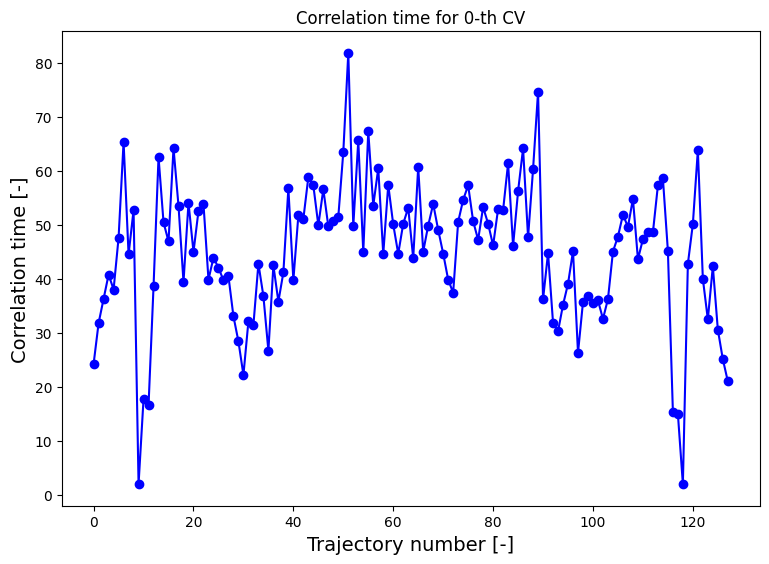

In [10]:
corrtimes = decorrelate(trajectories, plot=True)

In [11]:
bins = np.arange(-1.7,1.7, 0.02)
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.009s
  bias poten. : 00h 00m 00.007s
  solve scf   : 00h 00m 00.182s
  error est.  : 00h 00m 00.553s
  TOTAL       : 00h 00m 00.753s
---------------------------------------------------------------------


We can now plot the histogram and/or the free energy profile together with its error bar as well as 5 random samples of the FEP within the error bar.

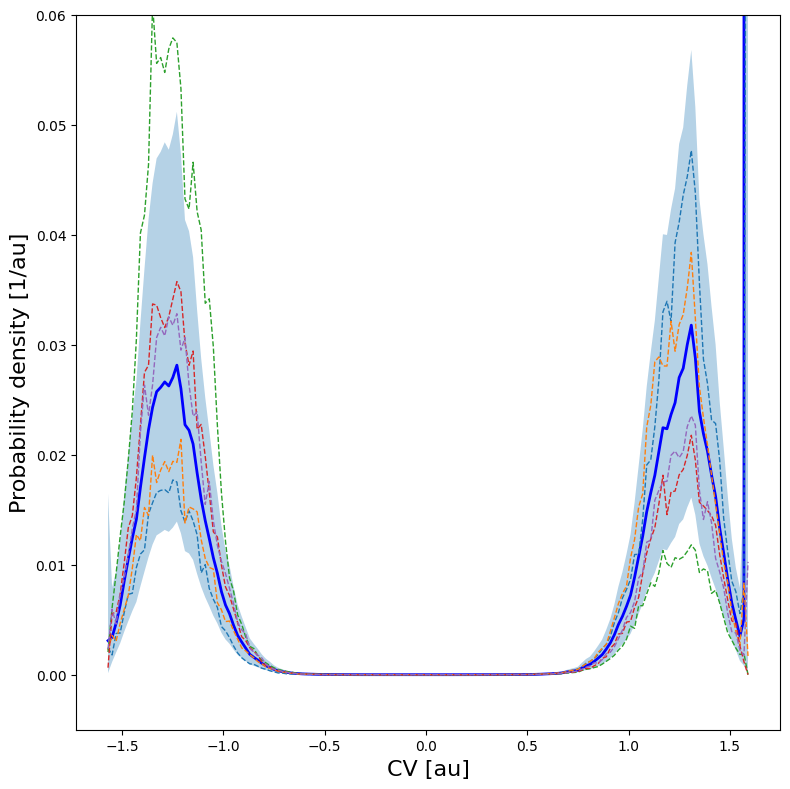

In [12]:
hist.plot(
    obss      =['mean'] +['sample',]*5, 
    linestyles=   ['-'] +    ['--',]*5,
    linewidths=     [2] +       [1,]*5,
    colors    =   ['b'] +     [None,]*5,
    plims=[-0.005,0.06], show_legend=False,
)

One can also plot various samples of the full profile taken according the error estimate:

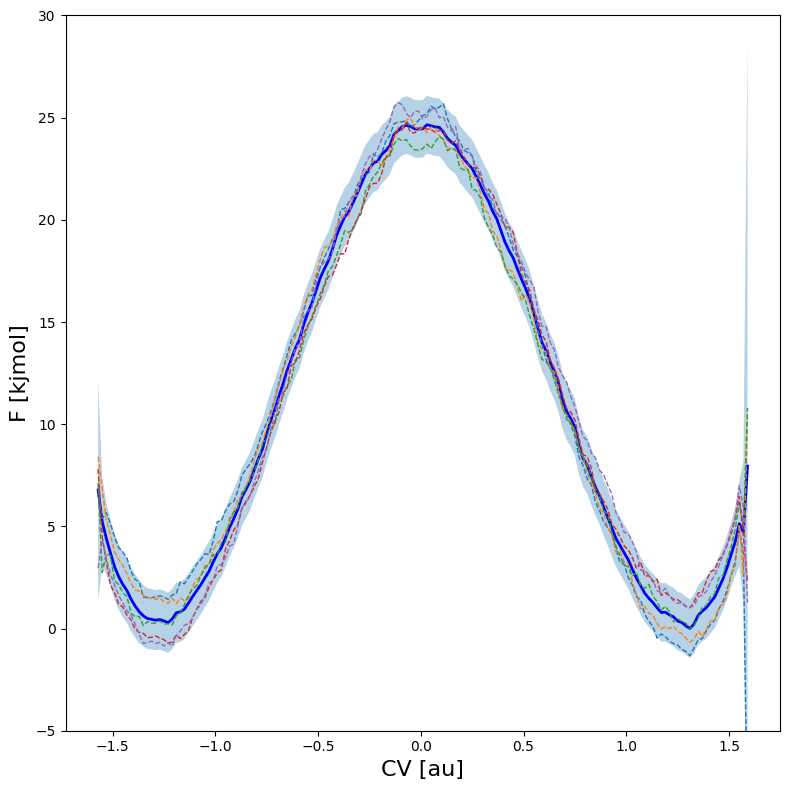

In [13]:
fep = BaseFreeEnergyProfile.from_histogram(hist, temp=temp)
fep.set_ref(ref='min')
fep.plot(
    obss      =['mean'] +['sample',]*5, 
    linestyles=   ['-'] +    ['--',]*5,
    linewidths=     [2] +       [1,]*5,
    colors    =   ['b'] +     [None,]*5,
    flims=[-5,30], show_legend=False,
)

Below, we briefly illustrate how the FEP would look like if we would only have done half the number of umbrella simulations (i.e. only include every other umbrella simulation, which still restults in overlap above 0.33):

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.005s
  bias poten. : 00h 00m 00.003s
  solve scf   : 00h 00m 00.214s
  error est.  : 00h 00m 00.268s
  TOTAL       : 00h 00m 00.491s
---------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

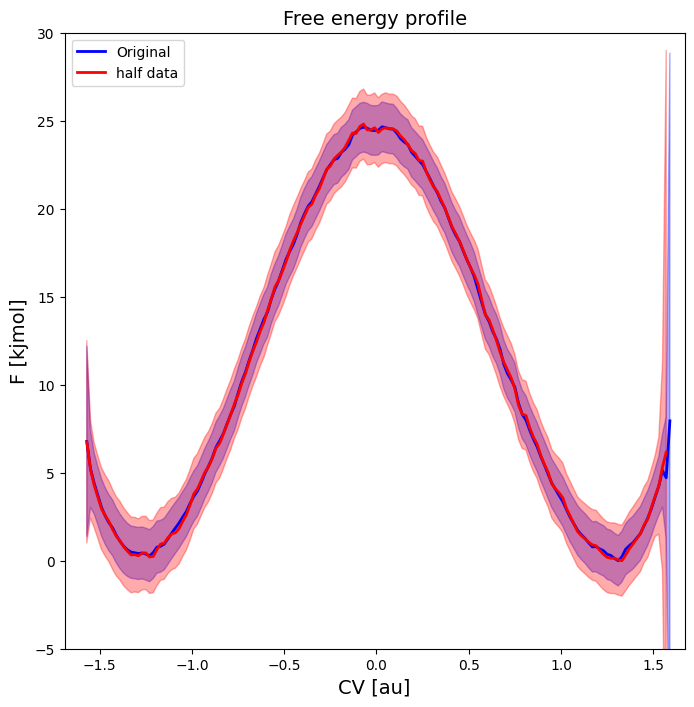

In [14]:
hist2 = Histogram1D.from_wham(bins, trajectories[::2], biasses[::2], temp, error_estimate='mle_f_cov', corrtimes=corrtimes[::2], Nscf=10000)
fep2 = BaseFreeEnergyProfile.from_histogram(hist2, temp=temp)
fep2.set_ref(ref='min')
plot_profiles([fep, fep2], labels=['Original','half data'], colors=['b','r'], flims=[-5,30])

As we can see, the profile still looks almost identical (maybe slightly less smooth), just with an increased error bar. Hence, overlap of 0.33 or higher seems to be OK (at least for this example). Finally, we can also make a matrix plot of the correlation between the free energy of different points on the fep:

<Figure size 640x480 with 0 Axes>

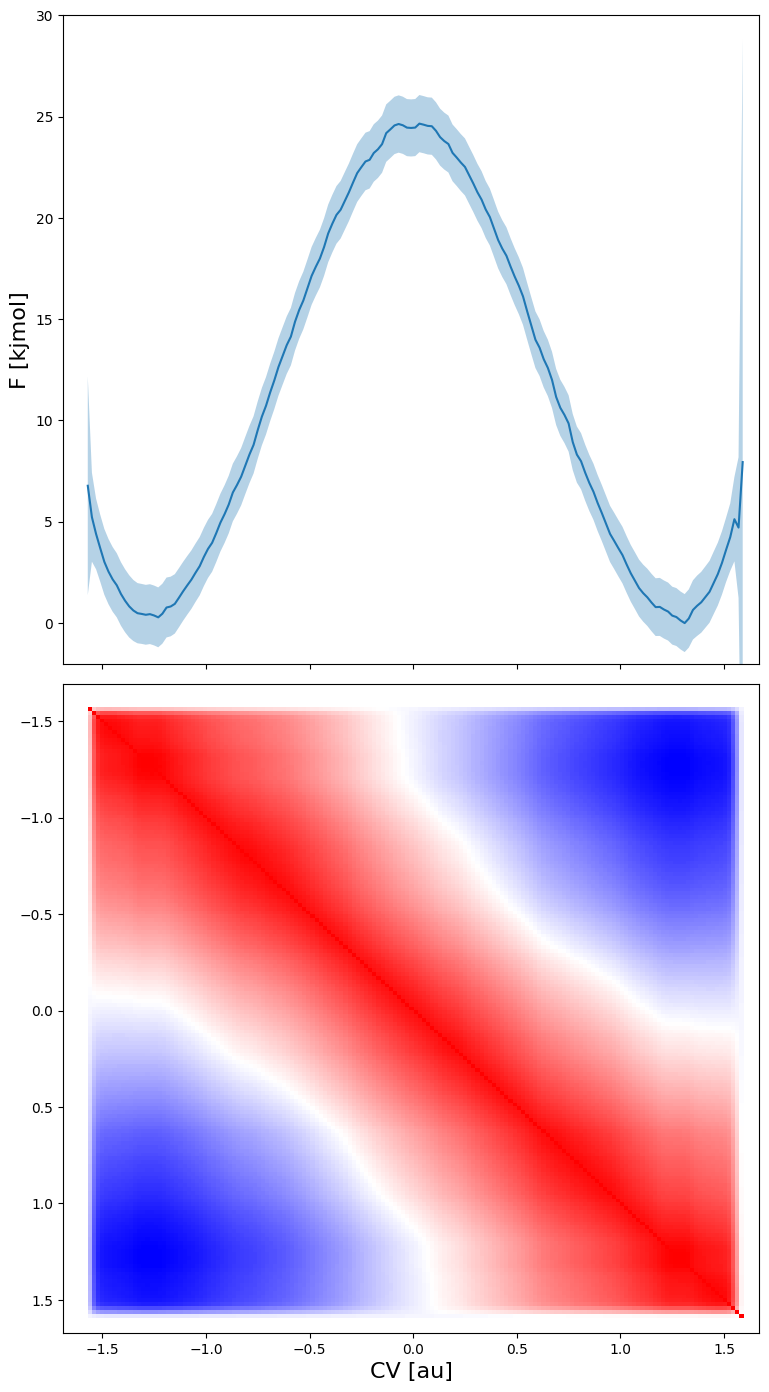

In [15]:
fep.plot_corr_matrix(flims=[-2,30], fn='basic_corrmatrixplot.pdf')

From the plot above (where blue means correlation of -1, red correlation of -1 and white correlation of 0) we can make the following interesting observations:
- the free energy of each point is strongly correlated with the free energy of neighboring points (red along the diagonal)
- the free energy of the reactant states is strongly anticorrelated with the free energy of the product states (blue in lower left and upper right region). This is due to the normalisation of the probability associated with the free energy. As the total probability is 1, if the probability of the reactant state would go up (decrease in free energy) the probability of the product state will need to go down (increase in free energy), giving rise to anticorrelation.
- The free energy of the transition state is uncorrelated with both reactant and product states (given by the white band separating the red diagonal and blue regions).

## Defining macrostates and microstates

In this section, we want to construct a free energy profile (FEP) on which we indicate macro and microstates. In the context of ThermoLIB, a microstate is defined as a single point on the free energy profile, while a macrostate is defined as a region on the free energy profile. The most obvious and usefull examples of both are: a transition state given by the local maximum on a FEP as a microstate, and the reactant/product defined as the region left/right of the transition state as a macrostate. The free energy of a microstate is just simply the corresponding free energy value on the FEP, the free energy of a macrostate is computed through application of boltzmann partition functions as follows:

$F_R = -k_BT\ln\left[\int_{-\infty}^{q^{TST}} e^{-\beta F(q)}dq\right]$

where $q^{TST}$ is the value of the CV in the transition state. In case of a macrostate, it might also be usefull to know the average (and variance) off the CV in the macrostate. All of these properties can be computed with ThermoLIB using the classes in the `thermolib.thermodynamics.state` module. To this end, we start from the free energy profile `fep` as computed in the previous section.

In [16]:
from thermolib.thermodynamics.state import Minimum, Maximum, Integrate
from thermolib.constants import boltzmann

#Define a local maximum located somewhere in the cv range [-0.5,0.5]:
ts = Maximum('TransState', cv_range=[-0.5,0.5])

#Define a local minima in the cv range [-inf, 0]
r = Minimum('MicroReac', cv_range=[-np.inf, 0])

#Define a macrostate as a collection (integration) of all microstates in a given cv_range=[left, right] where left/right can either be a Microstate (such as the above defined ts) or a float specifying the cv value. Let's consider the example of a reactant state defined a going from -inf to the transition state. As the integration is done over the corresponding boltzmann probabilities, we also need to definethe value of beta (=1/kT):
beta = 1.0/(boltzmann*300*kelvin)
R = Integrate('MacroReac', [-np.inf, ts], beta)

#Compute the value of the states for the previously construced FEP:
for state in [ts, R, r]:
    state.compute(fep)

In [17]:
#you can access the cv or f value by calling the get_cv() or get_f() routine:
for state in [ts, R, r]:
    cv = state.get_cv()
    F = state.get_F()
    print('%s:    cv = %.3f au     f  = %.3f kjmol' %(state.name, cv, F/kjmol))

TransState:    cv = -0.011 au     f  = 24.944 kjmol
MacroReac:    cv = -1.237 au     f  = 2.601 kjmol
MicroReac:    cv = -1.256 au     f  = 0.159 kjmol


In [18]:
#you can also print the print thermodynamic state properties more easily by calling its print routine:
lower, upper = r.F_dist.nsigma_conf_int(2)
error = (upper-lower)/2.0
error /= parse_unit("kjmol")

for state in [ts, r, R]:
    state.print()

MICROSTATE TransState:
--------------
  index =  None
  F     = 24.944 +- 1.255 kjmol
  CV    = -0.011 +- 0.138 au

MICROSTATE MicroReac:
--------------
  index =  None
  F     = 0.159 +- 1.370 kjmol
  CV    = -1.256 +- 0.092 au

MACROSTATE MacroReac:
--------------
  F       = 2.601 +- 1.441 kjmol
  CV Mean = -1.237 +- 0.020 au
  CV StD  = 0.161 +- 0.008 au



In case you have a free energy profile with two local minima separated by a single maximum, ThermoLIB can automatically detect the corresponding transition state (microstate corresponding to local maximum), reactant state (macrostate left of transition state) and product state (macrostate right of transition state). This is implemented in the SimpleFreeEnergyProfile class, which is a child class of BaseFreeEnergyProfile. Therefore, we either need to redo the from_histogram routine but starting from the SimpleFreeEnergyProfile instead of BaseFreeEnergyProfile, i.e. execute::

    fep_f = SimpleFreeEnergyProfile.from_histogram(hist, temp)

Or we simply convert the BaseFreeEnergyProfile to a SimpleFreeEnergyProfile as follows:

In [19]:
fep = SimpleFreeEnergyProfile.from_base(fep)

Now we use ThermoLIB to find the transition state by defining `ts_range` as the range of CV values in which we expect the maximum to be. We also specify an optional argument (cv_lims) in order to limit the overal CV range in all the routines related to finding micro/macrostates. This is usefull whenever the profile has very large error bars on the edges that might give rise to occasional samples in which that edge has a very low free energy (high probability) and hence distort the boltzmann distribution. In the current example this is indeed the case, therefore, we limit the overal CV range to `cv_lims=[-1.5,1.5]`. 

Next, ThermoLIB will automatically defines the reactant/product microstate (as a local minimum left/right of the transition state) as well as the Reactant/Product macrostate (as the integral over all microstates left/right of the transition state):

In [20]:
fep.process_states(lims=[-1.5,-0.5,0.5,1.5], verbose=True)

MICROSTATE ts:
--------------
  index =  None
  F     = 24.998 +- 1.282 kjmol
  CV    = -0.002 +- 0.136 au

MICROSTATE r:
--------------
  index =  None
  F     = 0.124 +- 1.592 kjmol
  CV    = -1.245 +- 0.080 au

MICROSTATE p:
--------------
  index =  None
  F     = 0.087 +- 1.508 kjmol
  CV    = 1.306 +- 0.040 au

MACROSTATE R:
--------------
  F       = 2.575 +- 1.260 kjmol
  CV Mean = -1.231 +- 0.018 au
  CV StD  = 0.146 +- 0.010 au

MACROSTATE P:
--------------
  F       = 2.474 +- 1.419 kjmol
  CV Mean = 1.237 +- 0.019 au
  CV StD  = 0.145 +- 0.009 au



If now plot the free energy profile using the `fep_f.plot(fn)` routine, we will also see the macrostates and microstates indicated:

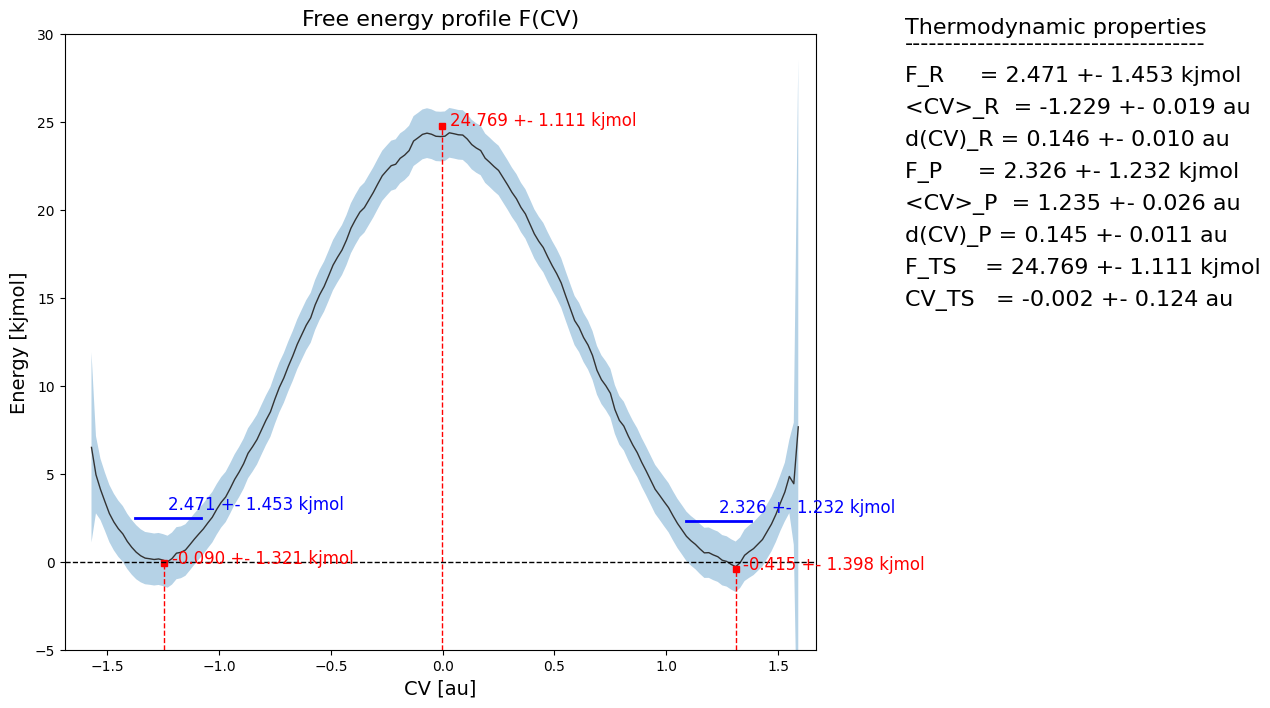

In [21]:
fep.set_ref(ref='r')
fep.plot(flims=[-5,30])